In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

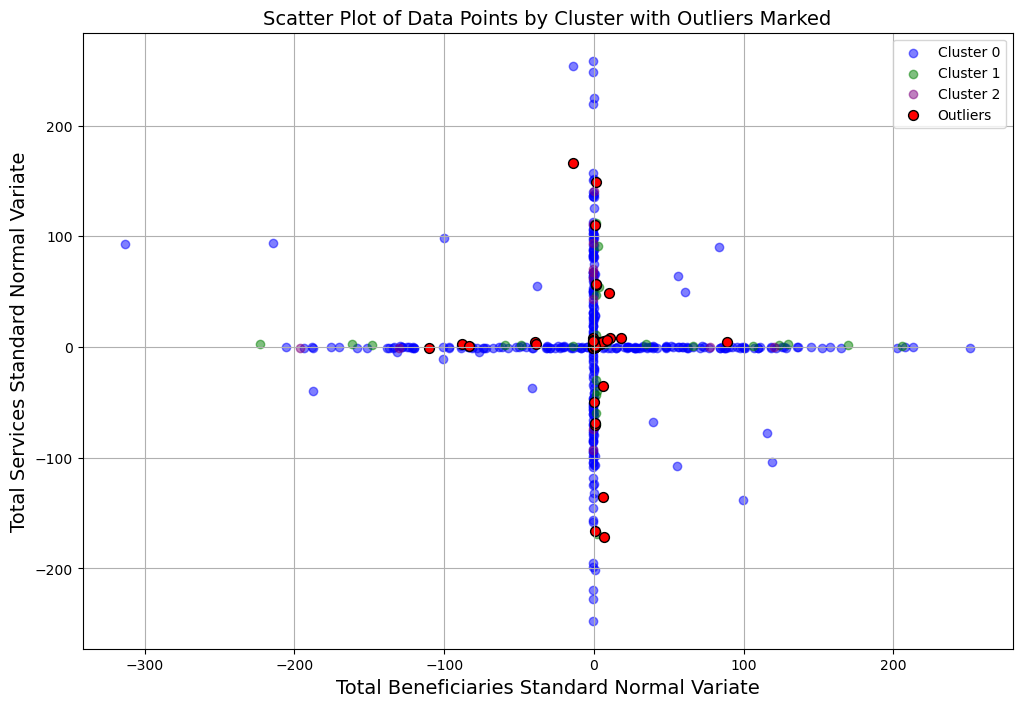

In [2]:
data = pd.read_csv('fisrt_half_original_data.csv')

# Define a function to calculate outliers based on the IQR
def calculate_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data[column] < lower_bound) | (data[column] > upper_bound)

# Select features for clustering
X = data[['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']]

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# Calculate distances from each point to its cluster center
distances = np.sqrt(((X - centroids[labels]) ** 2).sum(axis=1))
threshold = np.percentile(distances, 95)
data['Is_Outlier'] = distances > threshold
data['Cluster'] = labels  # Add cluster labels to the dataframe

# Apply IQR method to each column
data['IQR_Outlier_Tot_Benes'] = calculate_outliers_iqr(data, 'Tot_Benes_standard_normal_variate')
data['IQR_Outlier_Tot_Srvcs'] = calculate_outliers_iqr(data, 'Tot_Srvcs_standard_normal_variate')
data['IQR_Outlier_Avg_Mdcr_Amt'] = calculate_outliers_iqr(data, 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate')

# Combine the three IQR outlier columns into a single 'Actual_Outliers' column
data['Actual_Outliers'] = data[['IQR_Outlier_Tot_Benes', 'IQR_Outlier_Tot_Srvcs', 'IQR_Outlier_Avg_Mdcr_Amt']].any(axis=1)

# Function to add noise
def inject_noise(data, columns, fraction=0.1, noise_level=100):
    poisoned_data = data.copy()
    num_rows = len(data)
    num_poisoned = int(num_rows * fraction)

    for col in columns:
        std_val = poisoned_data[col].std()
        noise = np.random.normal(0, std_val * noise_level, num_poisoned)
        indices = np.random.choice(poisoned_data.index, size=min(num_poisoned, num_rows), replace=False)
        poisoned_data.loc[indices, col] += noise

    return poisoned_data

columns_to_add_noise = ['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']
noised_data = inject_noise(data, columns_to_add_noise)

# Plotting
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'purple']
for cluster in range(3):
    cluster_data = noised_data[noised_data['Cluster'] == cluster]
    plt.scatter(cluster_data['Tot_Benes_standard_normal_variate'], cluster_data['Tot_Srvcs_standard_normal_variate'], color=colors[cluster], label=f'Cluster {cluster}', alpha=0.5)

# Highlight outliers
outliers = noised_data[noised_data['Is_Outlier']]
plt.scatter(outliers['Tot_Benes_standard_normal_variate'], outliers['Tot_Srvcs_standard_normal_variate'], color='red', label='Outliers', edgecolor='k', s=50)

plt.title('Scatter Plot of Data Points by Cluster with Outliers Marked',fontsize=14)
plt.xlabel('Total Beneficiaries Standard Normal Variate',fontsize=14)
plt.ylabel('Total Services Standard Normal Variate',fontsize=14)
plt.legend()
plt.grid(True)
plt.show()
# Save the noised data with clusters, outlier flags, and actual outliers
noised_data.to_csv('First_half_data_noise_0.1_and_noise_level_100.csv', index=False)

Confusion Matrix:
[[1690   35]
 [ 197   65]]


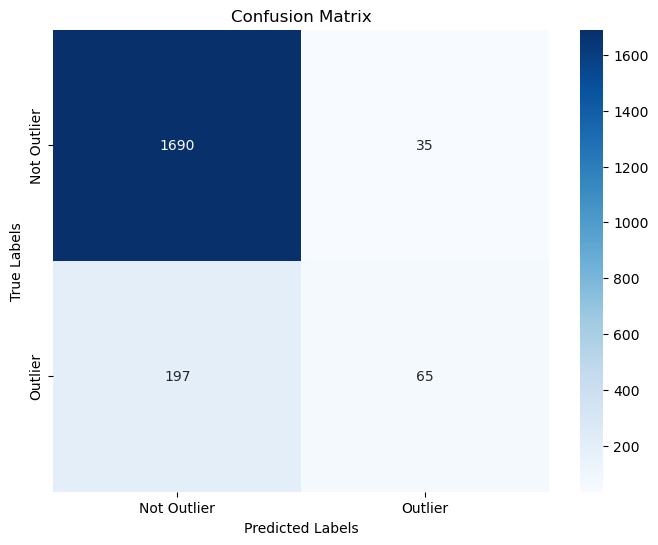

In [3]:
data = pd.read_csv('First_half_data_noise_0.1_and_noise_level_100.csv')

# Extract actual and predicted labels
actual_labels = data['Actual_Outliers']
predicted_labels = data['Is_Outlier']

# Calculate the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Outlier', 'Outlier'], yticklabels=['Not Outlier', 'Outlier'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [4]:
# Define the condition for each classification
conditions = [
    (actual_labels == False) & (predicted_labels == False),  # True Negative
    (actual_labels == False) & (predicted_labels == True),   # False Positive
    (actual_labels == True) & (predicted_labels == False),   # False Negative
    (actual_labels == True) & (predicted_labels == True)     # True Positive
]

# Define the label for each condition
labels = ['TN', 'FP', 'FN', 'TP']

# Create a new column in the dataframe that describes the classification of each data point
data['Classification'] = pd.Series(np.select(conditions, labels, default='Error'))

# Count the occurrences of each classification
classification_counts = data['Classification'].value_counts()

# Create a DataFrame for the counts
counts_df = pd.DataFrame(classification_counts).reset_index()
counts_df.columns = ['Classification', 'Count']

# Optionally print out the counts
print(counts_df)

# Save the modified data with the new classification to CSV
data.to_csv('modified_noise_data_with_classifications.csv', index=False)

# Save the counts to the same or a different CSV file
counts_df.to_csv('First-Half_data_classification_counts.csv', index=False)

# Optionally, print out a few rows to see the classifications
print(data[['Actual_Outliers', 'Is_Outlier', 'Classification']].head())

  Classification  Count
0             TN   1690
1             FN    197
2             TP     65
3             FP     35
   Actual_Outliers  Is_Outlier Classification
0            False       False             TN
1             True       False             FN
2            False       False             TN
3            False       False             TN
4            False       False             TN


In [9]:
def convert_or_flag(value):
    try:
        return float(value)
    except ValueError:
        return None
# Load and clean your datasets
data_original = pd.read_csv('fisrt_half_original_data.csv').applymap(convert_or_flag)
data_poisoned = pd.read_csv('First_half_data_noise_0.1_and_noise_level_100.csv').applymap(convert_or_flag)

# Drop rows with None values
data_original_clean = data_original.dropna()
data_poisoned_clean = data_poisoned.dropna()

In [12]:
import ruptures as rpt
# Change point detection function
def detect_change_points(data, column):
    # Convert column to array
    signals = data[column].values
    # Create a change point detection model and fit it
    model = "l1"  # Model using L1 norm (you can also use "l2", "rbf", etc.)
    algo = rpt.Pelt(model=model, min_size=1, jump=5).fit(signals)
    result = algo.predict(pen=3)
    
    # Plot
    rpt.display(signals, result, figsize=(10, 6))
    plt.title(f'Change Point Detection for {column}')
    plt.show()
    return result

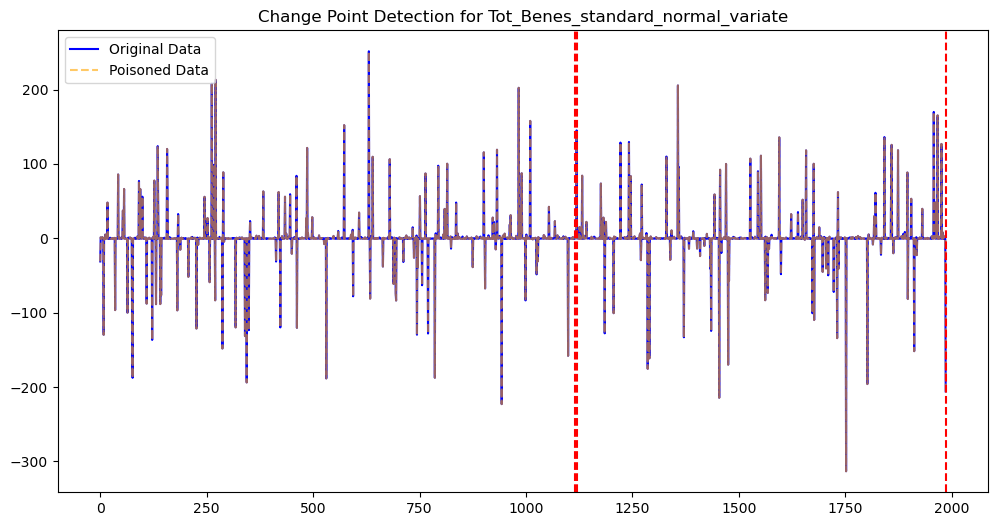

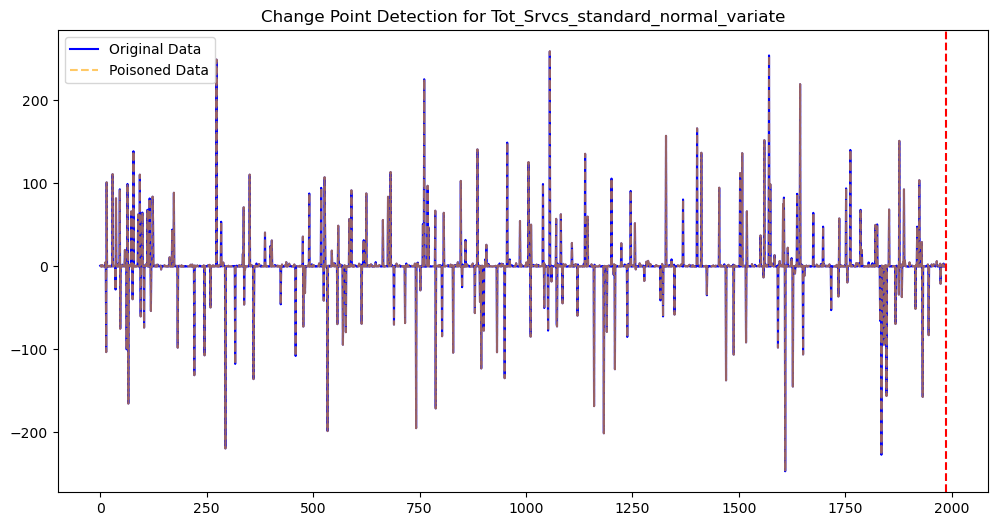

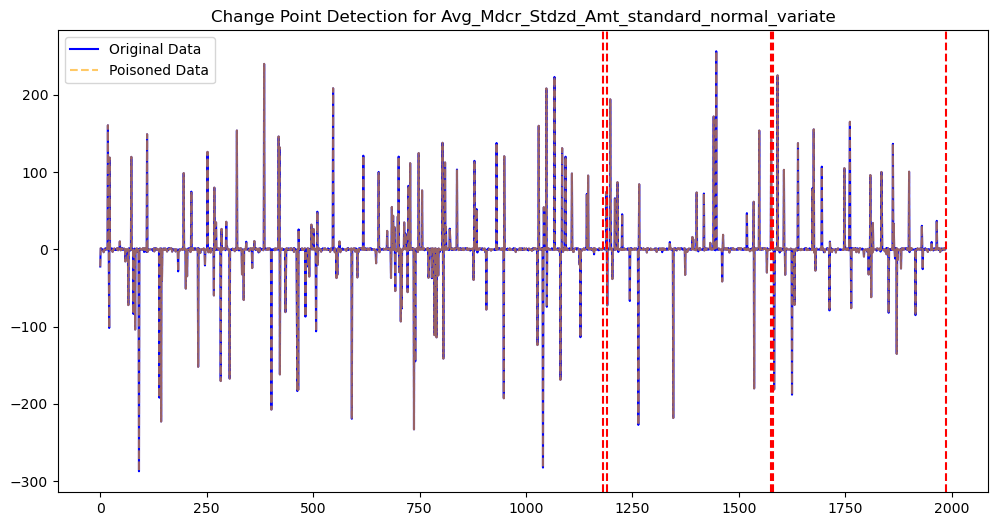

In [18]:
def detect_change_points(original_data, poisoned_data, column):
    # Convert columns to arrays
    original_signals = original_data[column].values
    poisoned_signals = poisoned_data[column].values
    
    # Create a change point detection model and fit it on poisoned data
    model = "l1"  # Model using L1 norm
    algo = rpt.Pelt(model=model, min_size=1, jump=5).fit(poisoned_signals)
    result = algo.predict(pen=3)
    
    # Plot original and poisoned data with change points
    plt.figure(figsize=(12, 6))
    plt.plot(original_signals, label='Original Data', color='blue')
    plt.plot(poisoned_signals, label='Poisoned Data', color='orange', linestyle='--', alpha=0.6)
    for cp in result:
        plt.axvline(cp, color='r', linestyle='--')
    plt.title(f'Change Point Detection for {column}')
    plt.legend()
    plt.show()
    
    return result

# Detect change points for each column and show the comparison
change_points_benes = detect_change_points(data, noised_data, 'Tot_Benes_standard_normal_variate')
change_points_srvcs = detect_change_points(data, noised_data, 'Tot_Srvcs_standard_normal_variate')
change_points_mdcr_amt = detect_change_points(data, noised_data, 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate')

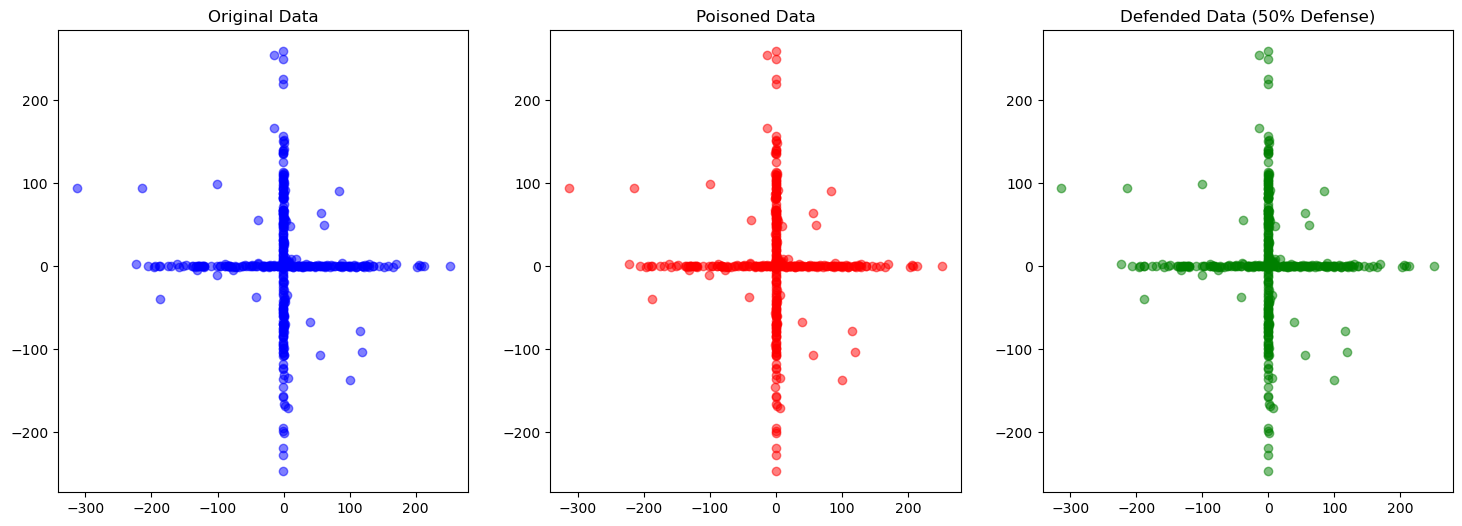

In [19]:
# Combine change points from all columns
all_change_points = set(change_points_benes + change_points_srvcs + change_points_mdcr_amt)
all_change_points = sorted(list(all_change_points - {len(noised_data)}))  # Remove the last change point which is the end of data

# Function to apply defense and save data based on percentage of identified change points
def apply_defense_and_save(data, change_points, defense_level):
    num_change_points = len(change_points)
    num_to_remove = int(num_change_points * defense_level / 100)
    
    if num_to_remove > 0:
        remove_indices = np.random.choice(change_points, size=num_to_remove, replace=False)
        data = data.drop(remove_indices)
    
    return data

# Apply the defender to catch 10%, 30%, 50% of the change points
defense_levels = [10, 30, 50]
for level in defense_levels:
    defended_data = apply_defense_and_save(noised_data.copy(), all_change_points, level)  # Ensure we use a copy of the noised data
    defended_data.to_csv(f'defended_data_{level}_percent.csv', index=False)

# Plotting the original, poisoned, and defended data
plt.figure(figsize=(18, 6))

# Plot original data
plt.subplot(1, 3, 1)
plt.title('Original Data')
plt.scatter(data['Tot_Benes_standard_normal_variate'], data['Tot_Srvcs_standard_normal_variate'], color='blue', alpha=0.5)

# Plot poisoned data
plt.subplot(1, 3, 2)
plt.title('Poisoned Data')
plt.scatter(noised_data['Tot_Benes_standard_normal_variate'], noised_data['Tot_Srvcs_standard_normal_variate'], color='red', alpha=0.5)

# Apply the defender to catch 50% of the change points and plot defended data
defended_data_50 = apply_defense_and_save(noised_data.copy(), all_change_points, 50)
plt.subplot(1, 3, 3)
plt.title('Defended Data (50% Defense)')
plt.scatter(defended_data_50['Tot_Benes_standard_normal_variate'], defended_data_50['Tot_Srvcs_standard_normal_variate'], color='green', alpha=0.5)

plt.show()

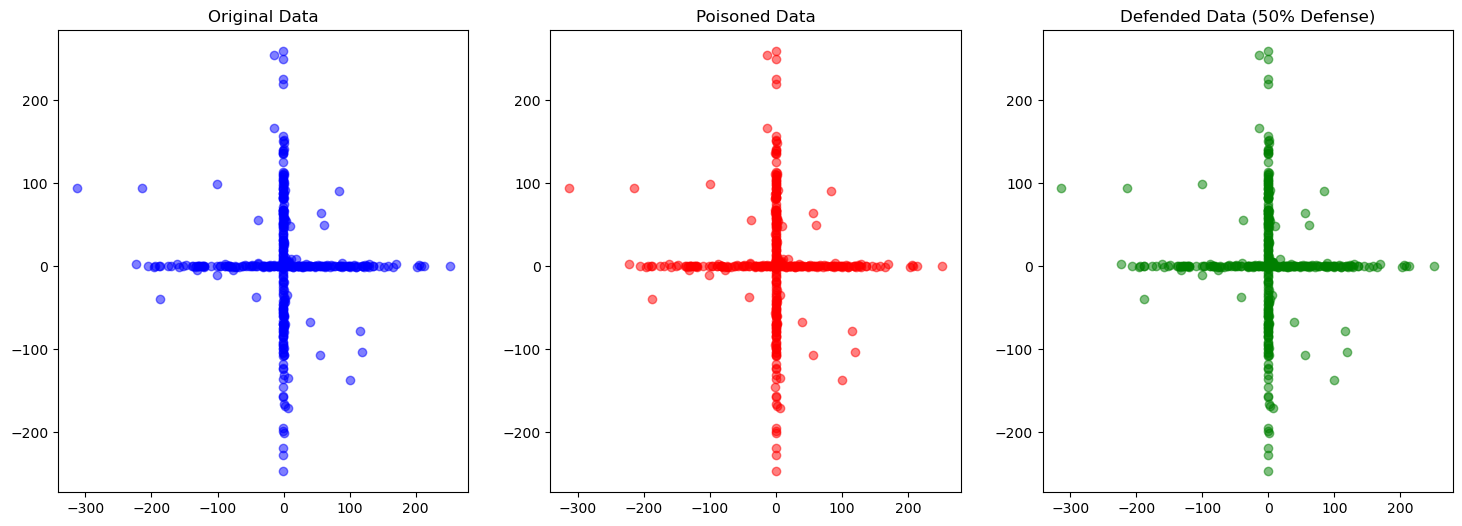

In [7]:
def defender(data, defense_level):
    suspicious_points = data[data['Is_Outlier']].index
    num_suspicious = len(suspicious_points)
    num_to_remove = int(num_suspicious * defense_level / 100)
    
    if num_to_remove > 0:
        remove_indices = np.random.choice(suspicious_points, size=num_to_remove, replace=False)
        data = data.drop(remove_indices)
    
    return data

# Apply the defender to catch 10%, 30%, 50% of the attacks
defense_levels = [10,30,50]
for level in defense_levels:
    defended_data = defender(noised_data, level)
    defended_data.to_csv(f'defended_data_{level}_percent.csv', index=False)

# Plotting the original, poisoned, and defended data
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Original Data')
plt.scatter(data['Tot_Benes_standard_normal_variate'], data['Tot_Srvcs_standard_normal_variate'], color='blue', alpha=0.5)

plt.subplot(1, 3, 2)
plt.title('Poisoned Data')
plt.scatter(noised_data['Tot_Benes_standard_normal_variate'], noised_data['Tot_Srvcs_standard_normal_variate'], color='red', alpha=0.5)

plt.subplot(1, 3, 3)
plt.title('Defended Data (50% Defense)')
defended_data_50 = defender(noised_data, 50)
plt.scatter(defended_data_50['Tot_Benes_standard_normal_variate'], defended_data_50['Tot_Srvcs_standard_normal_variate'], color='green', alpha=0.5)

plt.show()